(1001, 2, 128, 128)
(1002,)
torch.Size([1, 2, 32, 32])
torch.Size([1, 10, 2, 128, 128])
u max 2.329454214665961
u min -1.670545785334038
v max 0.9003832838290073
v min -2.950570761666368
relative error of u [0.03469036138409785, 0.06264960510916069, 0.09106070856151285, 0.1186685239591057, 0.1451460980150504, 0.17038034948212155, 0.19438671119313577, 0.2171432867389328, 0.23861881558251286, 0.25890218988869035]


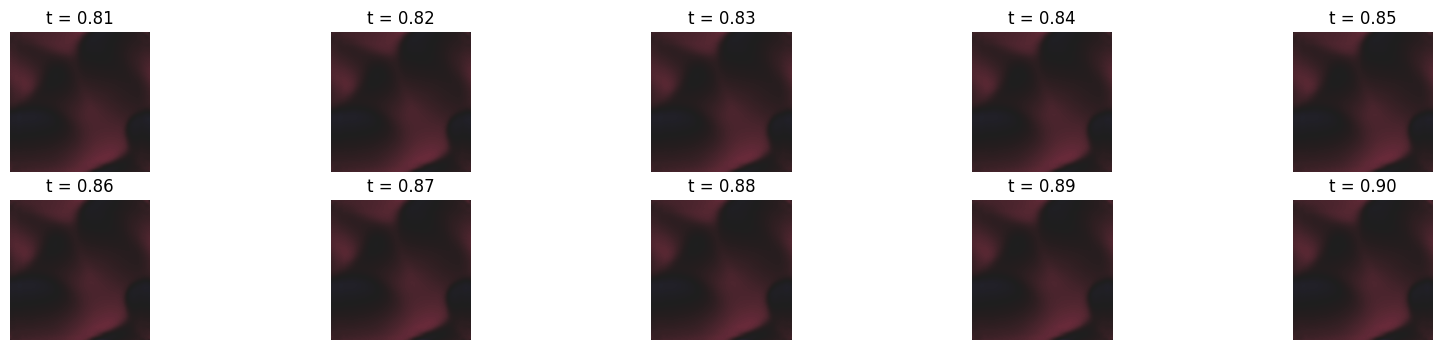

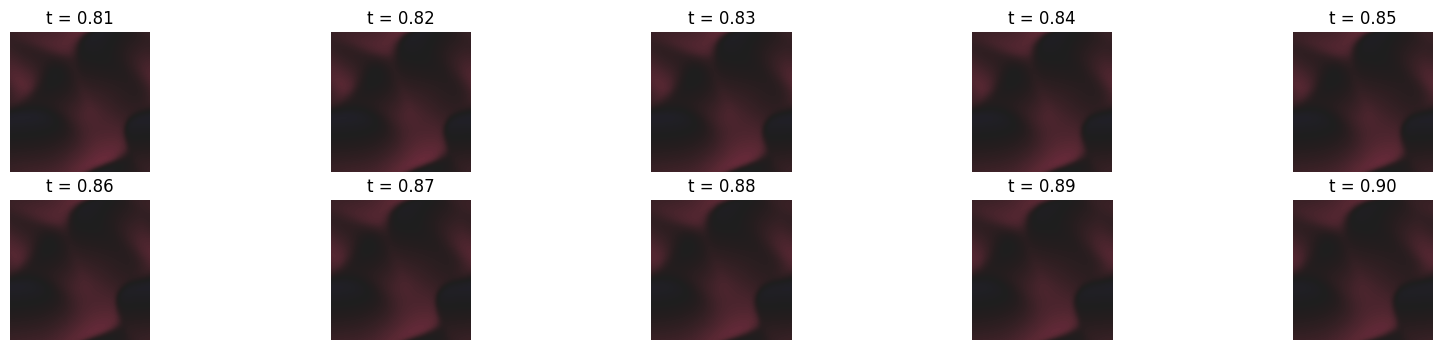

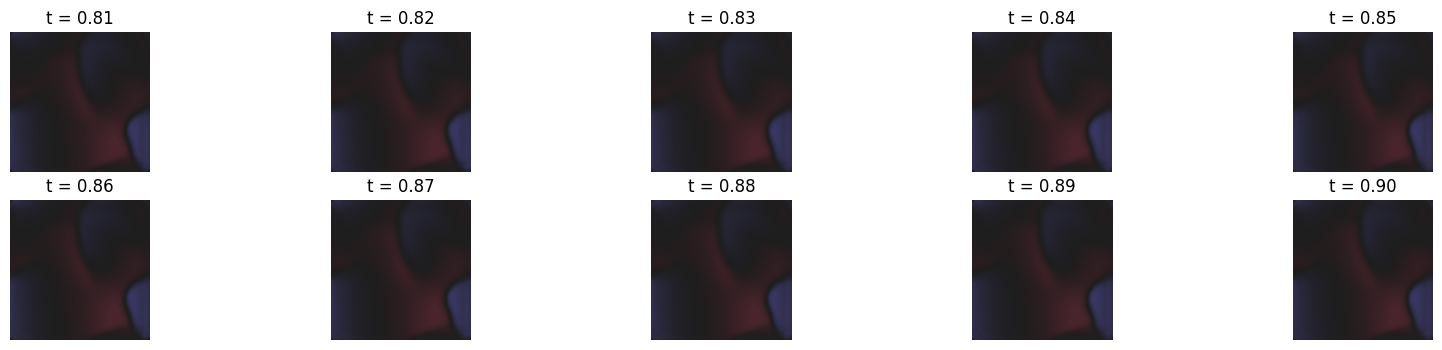

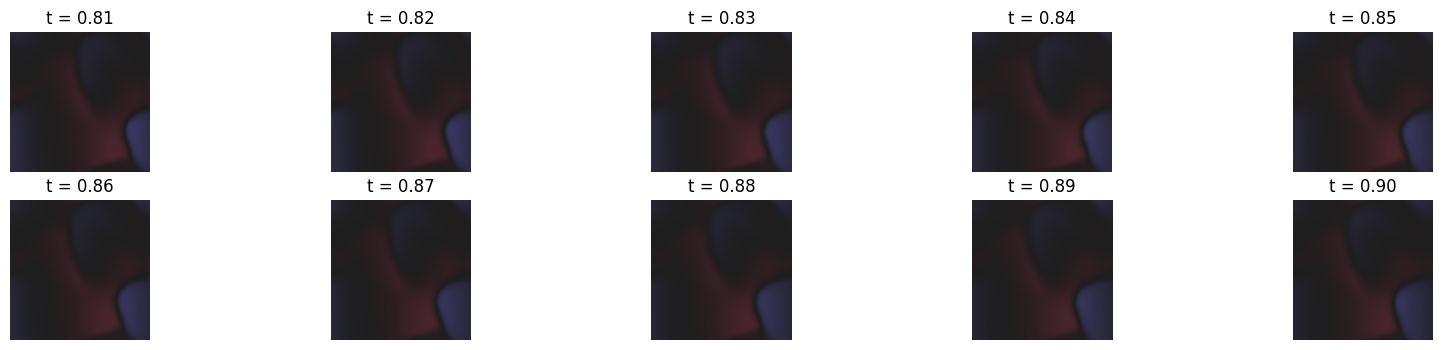

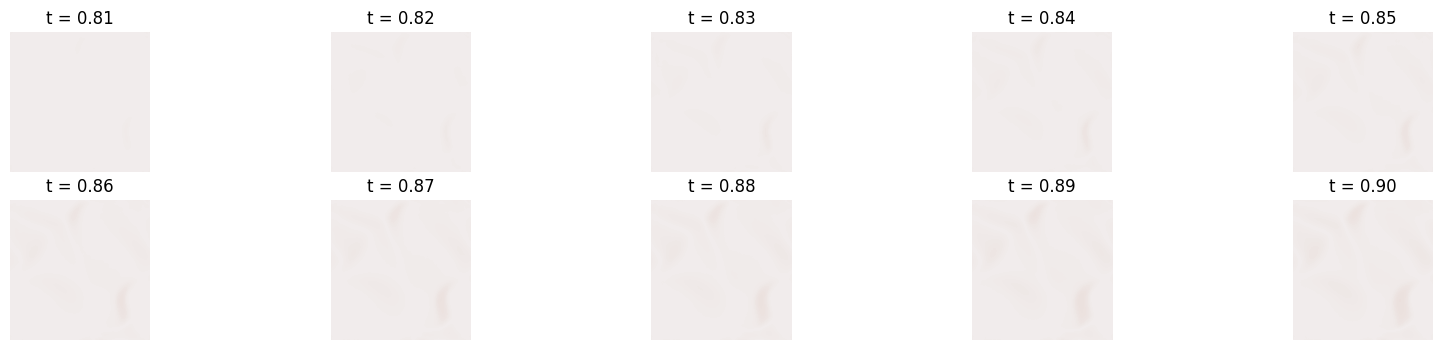

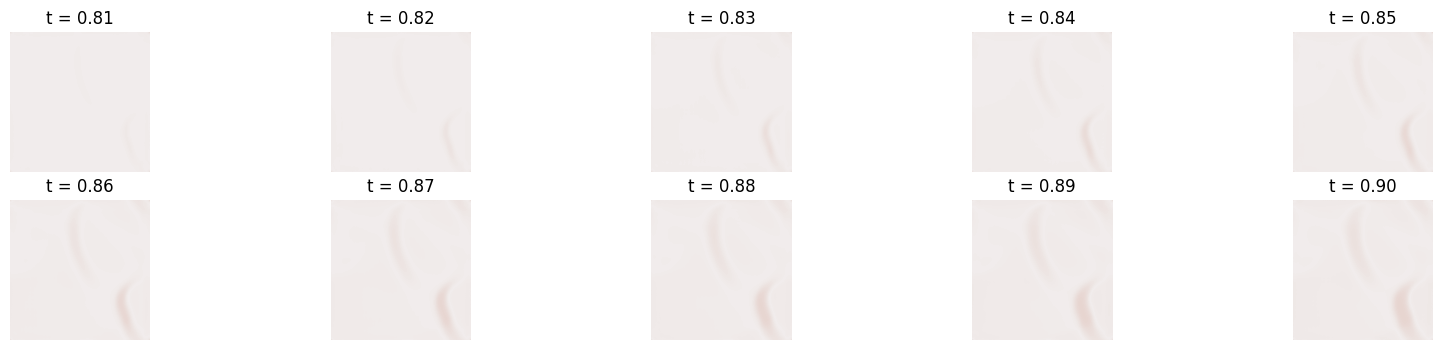

In [9]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn 
import cmocean
import argparse
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import numpy as np
import matplotlib.pyplot as plt

import logging
import torch.nn.init as init
from math import log10
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torchvision.transforms as transforms
from PIL import Image, ImageFilter
from os import listdir
from os.path import join
from scipy.io import loadmat
from tqdm import tqdm
import h5py
from src.models import *
from src.utli import *
from src.data_loader import getData
import logging
import argparse


f = h5py.File('../Fluid_PlayGround/Burgers_2D_small/test/Burgers2D_128x128_79.h5','r')
u = f['tasks']['u'][()]
v = f['tasks']['v'][()]
uv = np.stack([u,v],axis=1)
print(uv.shape)
t = f['tasks']['t'][()]
print(t.shape)
f.close()

transform = torch.from_numpy
upscale_factor = 4
img_shape_x = 128
img_shape_y = 128
input_transform = transforms.Resize((int(img_shape_x/upscale_factor),int(img_shape_y/upscale_factor)),Image.BICUBIC,antialias=False)
uv_tensor = transform(uv)
w_lr = input_transform(uv_tensor)

import torch
import torch.nn as nn
import torch.nn.functional as F
checkpoint = torch.load("results/PASR_MLP_small_data_Burger2D_small_crop_size_256_ode_step_8_ode_method_Euler_task_dt_4_num_snapshots_20_upscale_factor_4_timescale_factor_10_loss_type_L1_lamb_1.0_lr_0.0001_gamma_0.95_normalizaiton_Falsetensor([[2560]]).pt")
model = PASR_MLP(upscale=4, in_chans=2, img_size=256, window_size=8, depths=[6, 6, 6, 6], embed_dim=60, num_heads=[6, 6, 6, 6], mlp_ratio=2, upsampler="pixelshuffle", resi_conv='1conv',mean=[0],std=[1])

state_dict = {k[7:]:v for k, v in checkpoint["model_state_dict"].items()}
model.load_state_dict(state_dict)
model.eval()
model = model.cuda()

snapshot_num = 800
din = w_lr[snapshot_num].unsqueeze(0)
print(din.shape)
pred =  model(din.float().cuda(),task_dt = 4,
                                    n_snapshot = 10,ode_step = 8,
                                    time_evol = True)
print(pred.shape)

pred = pred.cpu().detach().numpy()
print(f"u max {uv[:,0].max()}")
print(f"u min {uv[:,0].min()}")
print(f"v max {uv[:,1].max()}")
print(f"v min {uv[:,1].min()}")
k =0 
fig, axs = plt.subplots(2, 5, figsize=(20, 4))
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        ax.axis('off')
        ax.set_title(f"t = {t[snapshot_num+(k+1)*10]:.2f}")
        ax.imshow(pred[0,k,0,:,:],cmap=seaborn.cm.icefire,vmin = -1.6,vmax = 2)
        k+=1

k= 0
fig, axs = plt.subplots(2, 5, figsize=(20, 4))
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        ax.axis('off')
        ax.set_title(f"t = {t[snapshot_num+(k+1)*10]:.2f}")
        ax.imshow(uv[snapshot_num+(k+1)*10,0,:,:],cmap=seaborn.cm.icefire,vmin = -1.6,vmax = 2)
        k+=1


k =0 
fig, axs = plt.subplots(2, 5, figsize=(20, 4))
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        ax.axis('off')
        ax.set_title(f"t = {t[snapshot_num+(k+1)*10]:.2f}")
        ax.imshow(pred[0,k,1,:,:],cmap=seaborn.cm.icefire,vmin = -3,vmax =0.9)
        k+=1
k= 0
fig, axs = plt.subplots(2, 5, figsize=(20, 4))
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        ax.axis('off')
        ax.set_title(f"t = {t[snapshot_num+(k+1)*10]:.2f}")
        ax.imshow(uv[snapshot_num+(k+1)*10,1,:,:],cmap=seaborn.cm.icefire,vmin = -3,vmax =0.9)
        k+=1


k =0
fig, axs = plt.subplots(2, 5, figsize=(20, 4))
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        ax.axis('off')
        ax.set_title(f"t = {t[snapshot_num+(k+1)*10]:.2f}")
        ax.imshow(np.abs(pred[0,k,0,:,:]-uv[snapshot_num+(k+1)*10,0,:,:]),cmap=cmocean.cm.amp,vmin = 0,vmax = 10)
        k+=1

k=0
fig, axs = plt.subplots(2, 5, figsize=(20, 4))
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        ax.axis('off')
        ax.set_title(f"t = {t[snapshot_num+(k+1)*10]:.2f}")
        ax.imshow(np.abs(pred[0,k,1,:,:]-uv[snapshot_num+(k+1)*10,1,:,:]),cmap=cmocean.cm.amp,vmin = 0,vmax = 10)
        k+=1

rfne = [np.linalg.norm(pred[0,i,0,:,:]-uv[snapshot_num+(i+1)*10,0,:,:])/np.linalg.norm(uv[snapshot_num+(i+1)*10,0,:,:]) for i in range(10)] 

print(f"relative error of u {rfne}")

/tmp/ipykernel_53971/2999928663.py:38: RuntimeWarning: invalid value encountered in scalar divide
  en[k] = en[k] / ic


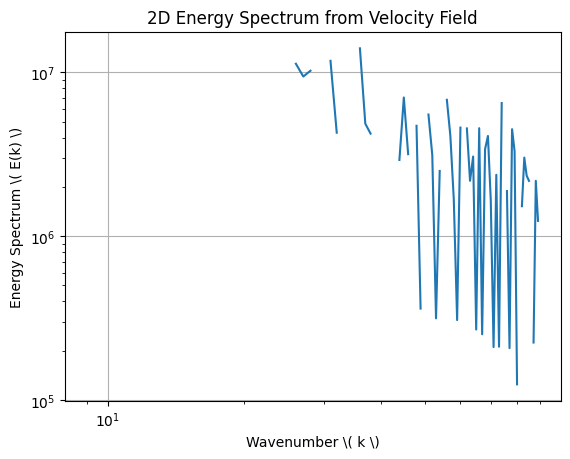

In [12]:
# Define the function to calculate the energy spectrum from velocity fields using NumPy's FFT
def energy_spectrum_velocity(nx, ny, u, v, dx):
    epsilon = 1.0e-6

    kx = np.empty(nx)
    ky = np.empty(ny)
    
    # Create the wavenumbers
    kx[0:int(nx/2)] = 2 * np.pi / (np.float64(nx) * dx) * np.float64(np.arange(0, int(nx/2)))
    kx[int(nx/2):nx] = 2 * np.pi / (np.float64(nx) * dx) * np.float64(np.arange(-int(nx/2), 0))
    ky[0:ny] = kx[0:ny]
    
    kx[0] = epsilon
    ky[0] = epsilon

    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    
    # Perform FFT on the velocity fields 'u' and 'v' using NumPy's FFT
    uhat = np.fft.fft2(u)
    vhat = np.fft.fft2(v)
    
    # Compute energy density
    energy_density = 0.5 * (np.abs(uhat)**2 + np.abs(vhat)**2)
    
    kk = np.sqrt(kx[:, :]**2 + ky[:, :]**2)
    
    n = int(np.sqrt(nx * nx + ny * ny) / 2.0) - 1
    en = np.zeros(n + 1)
    
    for k in range(1, n + 1):
        en[k] = 0.0
        ic = 0
        ii, jj = np.where((kk[1:, 1:] > (k - 0.5)) & (kk[1:, 1:] < (k + 0.5)))
        ic = ii.size
        ii = ii + 1
        jj = jj + 1
        en[k] = np.sum(energy_density[ii, jj])
        en[k] = en[k] / ic

    return en, n

# Generate some example data (replace this with your data)
# For demonstration purposes, random data is used
nx, ny = 128, 128
dx = 1.0/128  # Replace with your actual dx

# Calculate energy spectrum
en, n = energy_spectrum_velocity(nx, ny, uv[:,0], uv[:,1], dx)

# Plot the energy spectrum
k_values = np.arange(1, n + 1)
plt.loglog(k_values, en[1:])
plt.xlabel('Wavenumber \( k \)')
plt.ylabel('Energy Spectrum \( E(k) \)')
plt.grid(True)
plt.title('2D Energy Spectrum from Velocity Field')
plt.show()


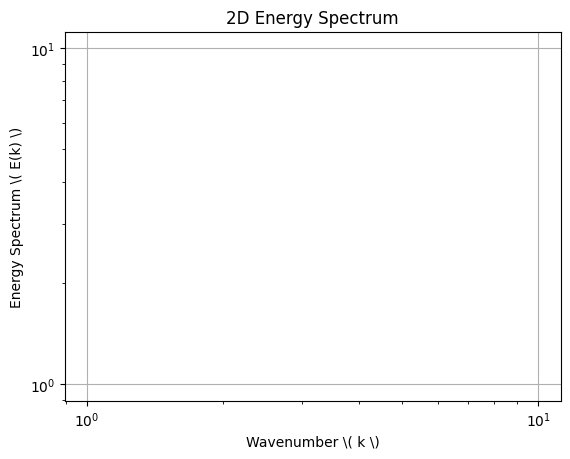

In [7]:
# Define the function to calculate the energy spectrum using NumPy's FFT
def energy_spectrum_np(nx, ny, w, dx):
    epsilon = 1.0e-6

    kx = np.empty(nx)
    ky = np.empty(ny)
    
    # Create the wavenumbers
    kx[0:int(nx/2)] = 2 * np.pi / (np.float64(nx) * dx) * np.float64(np.arange(0, int(nx/2)))
    kx[int(nx/2):nx] = 2 * np.pi / (np.float64(nx) * dx) * np.float64(np.arange(-int(nx/2), 0))

    ky[0:ny] = kx[0:ny]
    
    kx[0] = epsilon
    ky[0] = epsilon

    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    
    # Perform FFT on the vorticity field 'w' using NumPy's FFT
    wf = np.fft.fft2(w) 
    
    es = np.empty((nx, ny))
    
    kk = np.sqrt(kx[:, :]**2 + ky[:, :]**2)
    es[:, :] = np.pi * ((np.abs(wf) / (nx * ny))**2) / kk
    
    n = int(np.sqrt(nx * nx + ny * ny) / 2.0) - 1
    en = np.zeros(n + 1)
    
    for k in range(1, n + 1):
        en[k] = 0.0
        ic = 0
        ii, jj = np.where((kk[1:, 1:] > (k - 0.5)) & (kk[1:, 1:] < (k + 0.5)))
        ic = ii.size
        ii = ii + 1
        jj = jj + 1
        en[k] = np.sum(es[ii, jj])
        en[k] = en[k] / ic

    return en, n

# Generate some example data (replace this with your data)
# For demonstration purposes, random data is used
nx, ny = 64, 64
dx = 1.0  # Replace with your actual dx
w = np.random.rand(nx, ny)  # Replace this with your actual vorticity data

# Calculate energy spectrum
en, n = energy_spectrum_np(nx, ny, w, dx)

# Plot the energy spectrum
k_values = np.arange(1, n + 1)
plt.loglog(k_values, en[1:])
plt.xlabel('Wavenumber \( k \)')
plt.ylabel('Energy Spectrum \( E(k) \)')
plt.grid(True)
plt.title('2D Energy Spectrum')
plt.show()


(1002,)


IndexError: index 32 is out of bounds for axis 1 with size 2

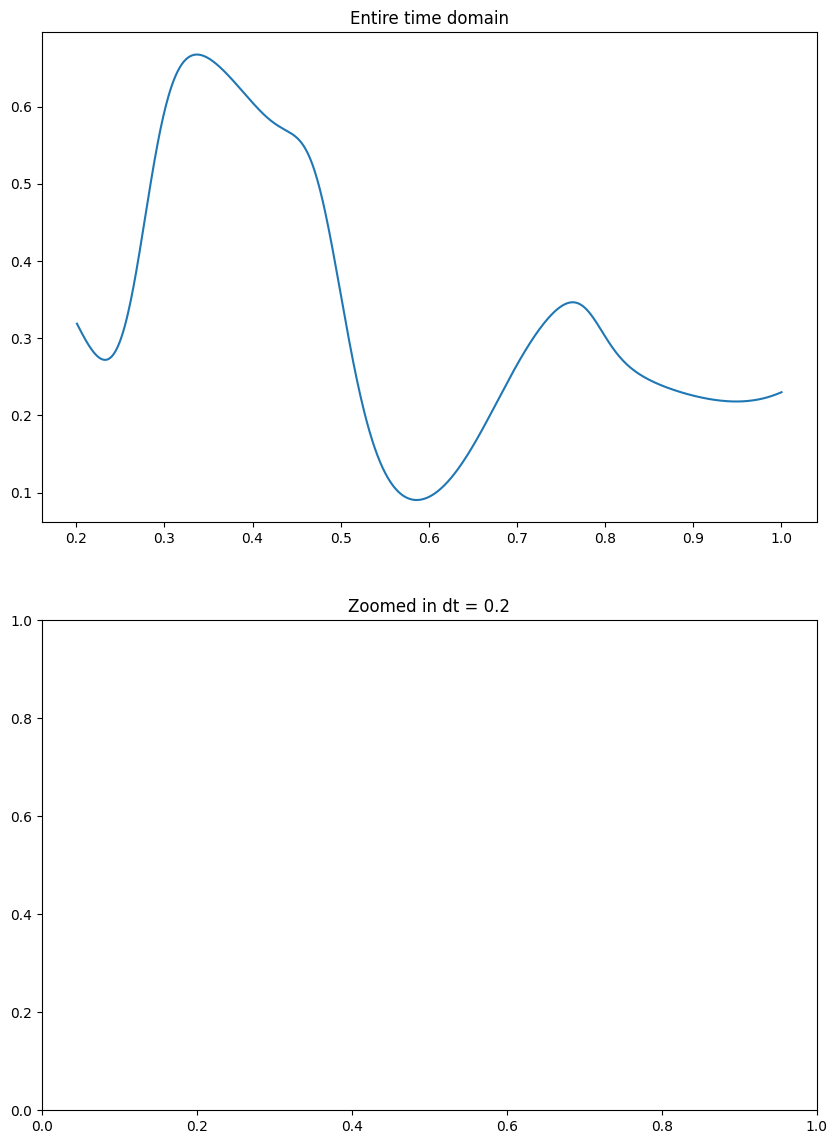

In [77]:
fig,ax = plt.subplots(2,1,figsize=(10,14))
print(t.shape)
ax[0].plot(t[201:],uv[200:,0,32,64])
ax[0].set_title("Entire time domain")
ax[1].set_title("Zoomed in dt = 0.2")
ax[1].plot(t[201:241],uv[201:241,0,32,64])
